# HHCART(D) on the Hamarat et al. 2013 Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from ema_workbench import load_results
from ema_workbench.analysis import RuleInductionType
from ema_workbench.analysis.feature_scoring import get_ex_feature_scores

from HHCART_SD import HHCartD, load_model
from notebook_helpers.plot_outcomes_lineplot_gaussian import plot_fraction_renewables
from notebook_helpers.clean_hamarat import clean_results
from notebook_helpers.run_hhcart_over_top_features import run_hhcart_over_top_features
# from notebook_helpers.plot_outcomes_lineplot_gaussian import plot_fraction_renewables
# from notebook_helpers.clean_hamarat import clean_results
# from notebook_helpers.run_hhcart_over_top_features import run_hhcart_over_top_features
from src.config.paths import HAMARAT_DATA_DIR

## Load and Clean the Data

In [2]:
# Load results
experiments, outcomes = load_results(HAMARAT_DATA_DIR / "10000_lhs_2010_2050.tar.gz")

# Clean data → get X and y
X, y_continuous = clean_results(experiments, outcomes)

 ## Plot the Data

Figure saved: renewables_over_time_0_6_threshold.pdf


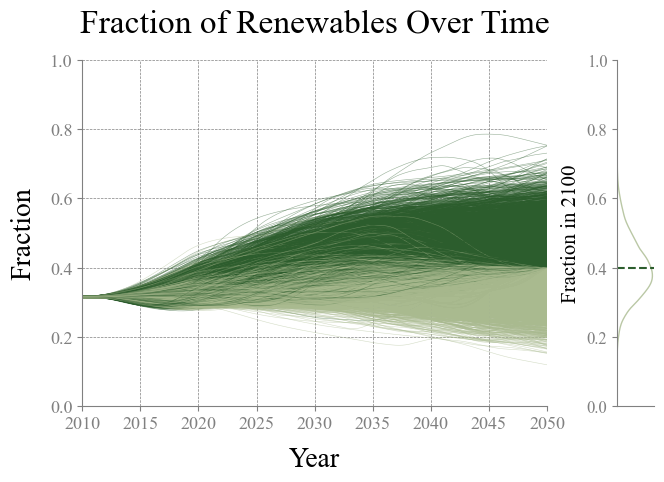


At threshold the threshold of 40.0% renewables by 2050:
46.4% of cases exceed threshold (4637 of 10000), 53.6% of cases fall below threshold (5363 of 10000)


In [3]:
plot_fraction_renewables(outcomes, threshold=0.4, save_path="renewables_over_time_0_6_threshold.pdf")

## Set Binary Threshold for y

In [4]:
threshold_value = 0.4  # for example
y = (y_continuous > threshold_value).astype(int)

In [5]:
# Convert categorical variables to dummy variables
categorical_cols = [col for col in X.columns if str(X[col].dtype) == 'category']
X_dummy = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype=float)

print(f"\nChanged categorical variables to dummy variables making the experiments Dataframe gain {X_dummy.shape[1]-X.shape[1]} columns.")


Changed categorical variables to dummy variables making the experiments Dataframe gain 22 columns.


In [ ]:
# # Drop SWITCH columns, as they are not needed for the analysis
# switch_cols = [col for col in X_dummy.columns if col.startswith("SWITCH")]
# X_encoded = X_dummy.drop(columns=switch_cols)

## Applying HHCART(D)

In [ ]:
# Set tree parameters
max_depth = 8
min_purity = 0.95
mass_min = 0.05

# Instantiate HHCART, build and save tree
hh = HHCartD(X_dummy, y, min_purity=min_purity, mass_min=mass_min, max_depth=max_depth)
hh.build_tree(f"hamarat_depth_{max_depth}_pur_{str(min_purity).replace('.', '_')}_mass_{str(mass_min).replace('.', '_')}")

In [ ]:
hh = load_model("hamarat_depth_8_pur_0_95_mass_0_05")
hh.select(depth=3)
hh.inspect()

In [ ]:
hh.plot_tree_structure(depth=6, save=True)

In [ ]:
hh.plot_metrics_vs_structure(save=True)

In [ ]:
hh.plot_metrics_vs_structure(save=True, x_axis="class1_leaf_count")

In [ ]:
hh.plot_tradeoff_path(save=True)

In [ ]:
hh.plot_tradeoff_path(save=True, color_by="class1_leaf_count")

In [ ]:
hh.plot_node_size_distribution(save=True)

## Applying Extra Trees Feature Scoring to Determine Features of Interest

In [6]:
feature_scores_class, model_class = get_ex_feature_scores(
    x=X_dummy,
    y=y,
    mode=RuleInductionType.CLASSIFICATION,
    nr_trees=250,
    max_features=None,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    oob_score=True,
    random_state=42
)

### Print the Top Features

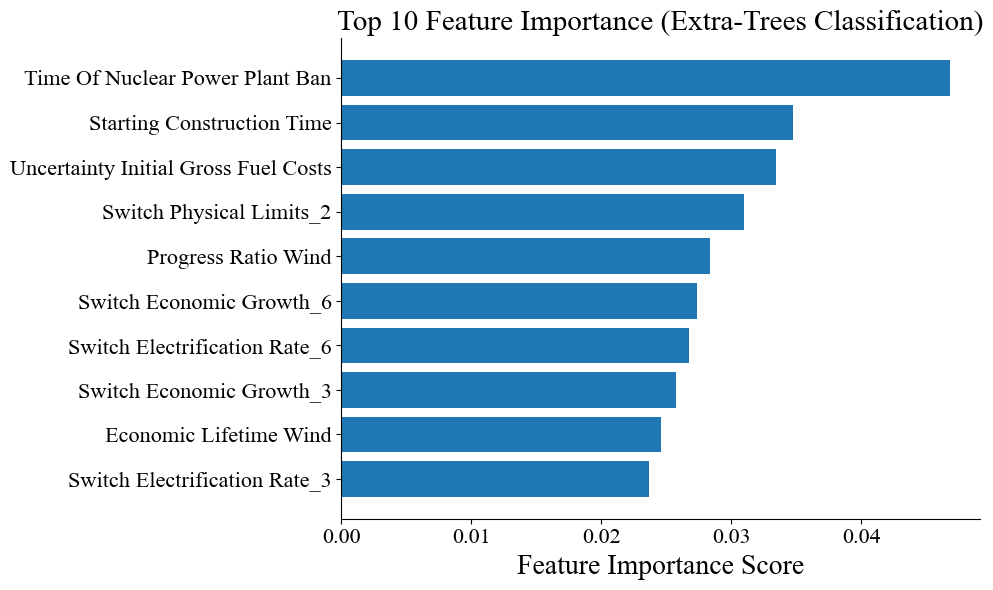

In [7]:
top_n = 10
top_features_class = feature_scores_class.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features_class.index, top_features_class.iloc[:, 0])  # assuming first column is the score
plt.xlabel('Feature Importance Score')
plt.title('Top 10 Feature Importance (Extra-Trees Classification)')
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()

In [8]:
# Convert to list of top features
top_features_ordered = feature_scores_class.index.tolist()

## Loop Over Top-N Features and Build HHCART(D)


[RUN] Building HHCartD with top 2 features: ['Time Of Nuclear Power Plant Ban', 'Starting Construction Time']
[INFO] Model title: hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:  16%|█▌        | 81/511 [03:09<16:46,  2.34s/it] 


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta
[OK] Selected tree at depth 0.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta/tree_structure_d0.pdf
[OK] Selected tree at depth 1.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta/tree_s

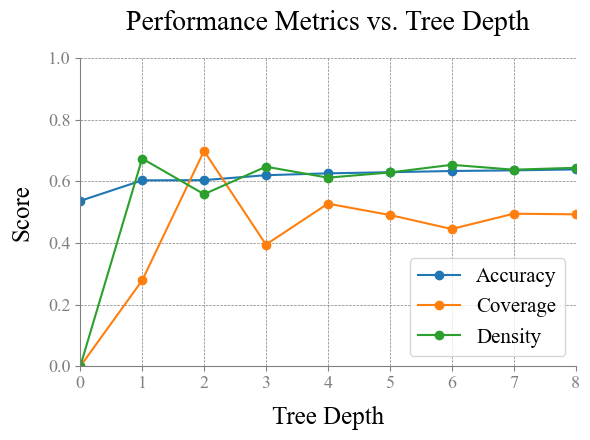

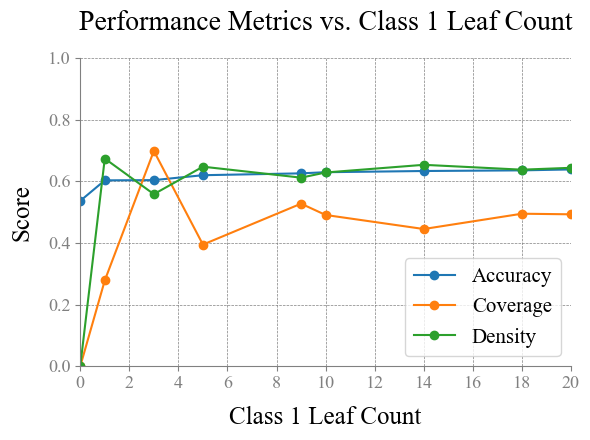

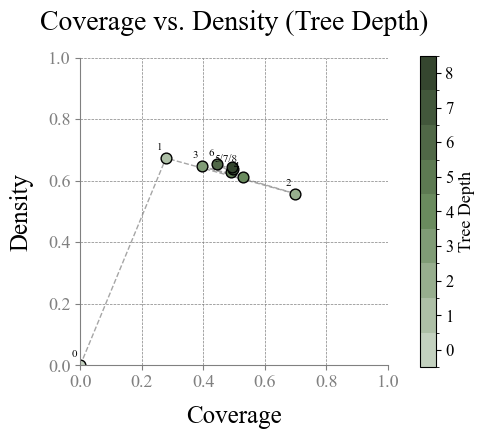

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta\coverage_density_path_class1_leaf_count.pdf


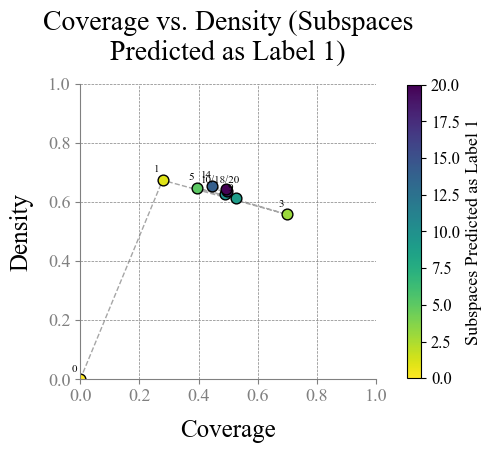

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta\node_size_distribution.pdf
[DONE] Finished run with top 2 features.

[RUN] Building HHCartD with top 3 features: ['Time Of Nuclear Power Plant Ban', 'Starting Construction Time', 'Uncertainty Initial Gross Fuel Costs']
[INFO] Model title: hhcart_top3f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:   9%|▉         | 47/511 [04:19<19:40,  2.54s/it]  

In [ ]:
# Run HHCART(D) over top features
run_hhcart_over_top_features(
    X_full=X_dummy,
    y=y,
    feature_scores=feature_scores_class,
    top_n_range=(2,9),
    max_depth=8,
    mass_min=0.05,
    min_purity=0.95,
    debug=False
)